## rate_density.ipynb 
Scripts to explore learning rules that produce particular probability density functions for the distribution of firing rates in a network.  
By Sergio Verduzco  
November 2017

Searching for ways to break the uniformity in E-I networks (all-or-none behaviour) I came up with this idea:

Let $u$ denote a stimulation level in a neural field. Not the stimulation level at any particular location, just a stimulation level.  
If the network has heterogeneous activation then you would expect that there would be a distribution of stimulation levels $\rho(u)$ that is not concentrated at a single value.  
The idea is to use steady-state weights $\omega$ that are a function of the activation levels, as in the steady-state when using a correlational learning rule.  
A self-consistency equation is:

$u = \int_\Re \omega(f(u), f(u')) \rho(u') du'$,

where $f = (1 + \text{e}^{-x})^{-1}$. For example, if you wanted a distribution of stimulations that was constant in the interval $[a, b]$ then you could use 

$u = \frac{1}{b-a} \int_{[a,b]} \omega(f(u), f(u')) du'$.

The solution to this self-consistency equation is not unique. A simple approach is to have $\omega(x,y) = f^{-1}(x) g(f^{-1}(y))$, where $\int_a^b g(u)du = 1$. For example, we can have $g(u) = 2u/(b^2-a^2)$.  
Considering that $f^{-1}(x) = - \text{log}\left(\frac{1-x}{x}\right)$, then for the simple case when we want our stimulations evenly distributed in the [0,1] interval, we would have the stationary weights:  
$\omega_s(x,y) = 2 \ \text{log}\left(\frac{1-x}{x} \right) \text{log}\left(\frac{1-y}{y} \right) $.

A learning rule to produce such stationary weight distribution could be:  
$\frac{d\omega}{dt} = \alpha \ (\omega_s - \omega) = \alpha \ \left( 2 \ \text{log}\left(\frac{1-x}{x} \right) \text{log}\left(\frac{1-y}{y} \right) - \omega \right)$,  
where $x$ and $y$ are presynaptic and postsynaptic activity respectively, although this rule is symmetric regarding pre and post switches.

The rule could be summarized as follows: changes are positive for similar activities, negative for different activities. Changes increase as activities move away from the point $(0.5, 0.5)$.
It is somewhat reminiscent of the correlation rule.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import numpy as np
import time
import dill
from draculab import *

In [24]:
# This is the name of the file where logging will happen
log_file = "rate_density_simlog.txt"

In [25]:
%%capture capt 
# logging draculab version used for this session
print('======================================================')
print('| Latest git commit: |')
print('======================================================')
!git log -1 --oneline --color=never

In [26]:
# Write the output of the cell above in the simulation log
with open(log_file, 'a') as f:
    f.write(capt.stdout)
    f.close()

In [32]:
# Some code to visualize the shape of the learning rule
f = lambda x: np.log( x/(1.-x) )
x = np.linspace(0.005, 0.99, 200)
#plt.plot(x, f(x))
y = np.linspace(0.005, 0.99, 200)
x,y = np.meshgrid(x,y)
k = np.exp(1.)/(1. - np.exp(-1))
#z = 0.1*f(x)*np.exp(y)/(y*(y-1))
z =  k * x * np.exp(y)/(144.*y*(1.-y))
%matplotlib qt5
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, rcount=60, ccount=60, antialiased=False)
ax.set_xlabel('post rate')
ax.set_ylabel('pre rate')
ax.set_zlabel('ss weight')
plt.show()

In [2]:
# The class used to run simulations and visualize results
class exp_distro():
    def __init__(self):
        # The history list will store strings containing the instructions doing parameter changes, 
        # building the network, or running a simulation.
        self.history = ["__init__ at " + time.ctime()]
        self.notes = '' # comments after visualizing simulation results
        # fixing random seed
        seed = 19680801
        np.random.seed(seed)
        # I also use the 'random' module, so I should also run random.seed(seed).
        self.history.append('np.random.seed = ' + str(seed))
        
        """ All the default parameter dictionaries are below. 
            Time units are seconds for compatibility with the pendulum model.
            Length units for geometry dictionaries are centimeters.
            Axonal conduction speed is ~1 m/s, synaptic delay about 1 ms, but 5 ms for the population response.
        """
        # parameter dictionary for the network
        self.net_params = {'min_delay' : 0.005, # notice delays below are set using this value
                           'min_buff_size' : 10,
                           'rtol' : 1e-5,
                           'atol' : 1e-5 } 
        # parameter dictionaries for the units
        self.geom = {'shape':'sheet', 
                     'extent':[1.,1.], # 1 square centimeter grid
                     'center':[0.,0.], 
                     'arrangement':'grid', 
                     'rows':25, 
                     'columns':25,  # 625 units
                     'jitter' : 0.02 }
        self.unit_pars = {'init_val' : np.random.rand(self.geom['rows']*self.geom['columns']), 
                          'slope' : 1.,
                          'thresh' : 0.,
                          'tau' : 0.02,  # 20 ms time constant
                          'tau_fast' : 0.04, # 40 ms for fast low-pass filter
                          'tau_mid' : .1, # 100 ms for medium low-pass filter
                          'type' : unit_types.sigmoidal }
        # parameter dictionary for the inputs. Weight tracking units use the same dictionary.
        self.n_units = {'inp' : 1, # number of input units
                        'w_track': 6 } # number of weight tracking units
        self.inp_pars = {'type' : unit_types.source,
                         'init_val' : 0.,
                         'tau_fast' : 0.04,
                         'coordinates' : np.array([0.,0.]), # for plotting purposes
                         'function' : lambda x: None }
        # connections among units
        self.conn = {'connection_type' : 'divergent',
            'mask' : {'circular': {'radius': 10.}}, # contains all the unit grid for all-to-all connectivity
            'kernel' : 1.,
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 10.}},
            'weights' :{'uniform' : {'low': -0.5, 'high' : 0.5}},
            'allow_autapses' : True,
            'allow_multapses' : False,
            'edge_wrap' : False,
            'boundary' : {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']} }
        self.syn = {'type' : synapse_types.exp_rate_dist,
                    'lrate' : 0.05,
                    'c' : 1. }
        # Input connections
        self.i2u_conn = {'rule' : 'all_to_all',
                 'delay' : self.net_params['min_delay'] }
        self.i2u_syn = {'type' : synapse_types.static,
                'lrate' : 0.05,
                'init_w' : {'distribution' : 'equal_norm', 'norm' : 1.} }
        
        
    def build(self):
        """ Create the draculab network. """
        # store record of network being built
        self.history.append('build()')
        # Set derived parameters
        self.conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.conn['boundary'] = {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']}
        self.unit_pars['init_val'] = np.random.rand(self.geom['rows']*self.geom['columns'])
        # Create an auxiliary topology object
        topo = topology()
        # Create network
        self.net = network(self.net_params)
        # Create unit population
        self.units = topo.create_group(self.net, self.geom, self.unit_pars)
        # Create input units
        self.inp = self.net.create(self.n_units['inp'], self.inp_pars)
        # Create weight tracking units
        self.w_track = self.net.create(self.n_units['w_track'], self.inp_pars)
        # Create connections
        topo.topo_connect(self.net, self.units, self.units, self.conn, self.syn)
        self.net.connect(self.inp, self.units, self.i2u_conn, self.i2u_syn)
        # Set the function of the w_track units to follow randomly chosen weights
        n_u = int(np.floor(np.sqrt(self.n_units['w_track']))) # For how many units we'll track weights
        n_syns, remainder = divmod(self.n_units['w_track'], n_u) # how many synapses per unit
        which_u = np.random.choice(self.units, n_u) # ID's of the units we'll track
        which_syns = [[] for i in range(n_u)]
        for uid,u in enumerate(which_u[0:-1]):
            which_syns[uid] = np.random.choice(range(len(self.net.syns[u])), n_syns)
        which_syns[n_u-1] = np.random.choice(range(len(self.net.syns[which_u[-1]])), n_syns+remainder)
        for uid,u in enumerate(which_u):
            for sid,s in enumerate(which_syns[uid]):
                self.net.units[self.w_track[uid*n_syns+sid]].set_function(self.net.syns[u][s].get_w)
        
    def set_param(self, dictionary, entry, value):
        """ Change a value in a parameter dictionary. 
        
            dictionary: a string with the name of one of the parameter dictionaries in __init__
            entry: a string with the name of the entry we'll modify
            value: the value we'll assign (can be any appropriate Python object) 
        """
        if 'build()' in self.history:
            raise AssertionError('Setting a parameter value after network has been built')     
        self.__getattribute__(dictionary)[entry] = value  # set the new value
        self.history.append(dictionary + '[\'' + entry + '\'] = ' + str(value) ) # record assignment
            
    def make_sin_pulse(self, t_init, t_end, per, amp): 
        """ This function returns a function implementing a localized sinusoidal bump(s). """
        return lambda t : amp * ( np.sqrt( 0.5 * (1. + 
                      np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) ) ) ) if (t_init < t and t < min(t_init+per,t_end)) else 0.
    
    def input_vector(self):
        """This function returns an input vector. Different distributions can be implemented with this. """
        ## random vector with unit norm, positive entries
        # vec = np.random.uniform(0., 1., self.n_units['inp'])
        # return  vec / np.linalg.norm(vec)
        
        ## random vector with unit norm, positive and negative entries
        vec = np.random.uniform(0., 1., self.n_units['inp']) - np.random.uniform(0., 1., self.n_units['inp'])
        return  vec / np.linalg.norm(vec)
        
    def run(self, n_pres, inp_time, inp_amp, pres_time, alpha=0.):
        """ Run a simulation, presenting n_pres patterns, each lasting pres_time, 
            with inputs of amplitude inp_amp and lasting inp_time at the beginning of each presentation.
            
            The argument alpha determines how fast the input amplitudes drift.
            
            Updates:
                self.all_times: 1-D numpy array with the times for each data point in all_activs.
                self.all_activs: 2-D numpy array with the activity of all units at each point in all_times. 
        """
        # store a record of this simulation
        self.history.append('run(%d, %f, %f, %f, %f)' % (n_pres, inp_time, inp_amp, pres_time, alpha)) 
        # initialize storage of results
        self.all_times = []
        self.all_activs = []
        start_time = time.time()
        inp_vel = np.zeros(self.n_units['inp']) # initial velocity for the input drift
        inp_vec = inp_amp*self.input_vector() # initial amplitudes of the inputs
        # present input patterns
        for pres in range(n_pres):
            print('Simulating presentation ' + str(pres), end='\r')
            pres_start = time.time()
            t = self.net.sim_time
            inp_accel = inp_amp*self.input_vector() # having an acceleration confers "momentum" to the input drift
            inp_vel = (1.-alpha)*inp_vel + alpha*inp_accel 
            inp_vec = (1.-alpha)*inp_vec + alpha*inp_vel
            for i in self.inp:
                self.net.units[i].set_function(self.make_sin_pulse(t, t+pres_time, inp_time, inp_vec[i-self.inp[0]]))
        
            times, activs, plants = self.net.run(pres_time)
            self.all_times.append(times)
            self.all_activs.append(activs)
            print('Presentation %s lasted %s seconds.' % (pres, time.time() - pres_start), end='\n')

        self.all_times = np.concatenate(self.all_times)
        self.all_activs = np.concatenate(self.all_activs, axis=1)
        print('Execution time is %s seconds' % (time.time() - start_time)) 
        return self # see rant on multiprocessing    
    
    def basic_plot(self):
        #%matplotlib inline
        inp_fig = plt.figure(figsize=(10,5))
        inputs = np.transpose([self.all_activs[i] for i in self.inp])
        plt.plot(self.all_times, inputs, linewidth=1, figure=inp_fig)
        plt.title('Inputs')

        unit_fig = plt.figure(figsize=(10,5))
        some_acts = np.transpose(self.all_activs[[self.units[i] for i in [0,1,-1,-2]]])
        plt.plot(self.all_times, some_acts, figure=unit_fig)
        plt.title('Some unit activities')
        
        # Plot the evolution of the synaptic weights
        w_fig = plt.figure(figsize=(10,5))
        weights = np.transpose([self.all_activs[self.w_track[i]] for i in range(self.n_units['w_track'])])
        plt.plot(self.all_times, weights, linewidth=1)
        plt.title('Some synaptic weights')

        plt.show()
        
    def activ_anim(self, thr, interv=100, slider=False):
        """ An animation to visualize the activity of the excitatory units. 
        
            interv : refresh interval of the simulation.
            slider : When set to True the animation is substituted by a slider widget.
            
            Units whose activity surpasses 'thr' will be highlighted.
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib qt5
        # notebook or qt5 

        self.unit_fig = plt.figure(figsize=(10,10))
        self.ax = self.unit_fig.add_axes([0, 0, 1, 1], frameon=False)
        self.ax.set_xlim(-1, 1), self.ax.set_xticks([])
        self.ax.set_ylim(-1, 1), self.ax.set_yticks([])
        xcoords = [ u.coordinates[0] for u in [self.net.units[i] for i in self.units] ]
        ycoords = [ u.coordinates[1] for u in [self.net.units[i] for i in self.units] ]
        self.scat = self.ax.scatter(xcoords, ycoords, s=20.*self.all_activs[self.units,0])
        self.n_data = len(self.all_activs[0])
        self.act_thr = thr
        
        if not slider:
            animation = FuncAnimation(self.unit_fig, self.update_act_anim, 
                                  interval=interv, save_count=int(round(self.net.sim_time/self.net.min_delay)))    
            return animation
        else:
            from ipywidgets import interact
            widget = interact(self.update_act_anim, frame=(1,self.n_data))
            return widget
        
    def color_fun(self, activ):
        # given the units activity, maps into a color. activ may be an array.
        activ =  np.maximum(0.1,  activ*np.maximum(np.sign(activ - self.act_thr), 0.))
        return np.outer(activ, np.array([0., .5, .999, .5]))

    def update_act_anim(self, frame):
        # Each frame advances one simulation step (min_delay time units)
        idx = frame%self.n_data
        cur_time = self.net.min_delay*idx
        self.scat.set_sizes(300.*self.all_activs[self.units,idx])
        self.scat.set_color(self.color_fun(self.all_activs[self.units,idx]))
        self.unit_fig.suptitle('Time: ' + '{:f}'.format(cur_time))
        return self.ax,
    
    def conn_anim(self, source, sink, interv=100, slider=False, weights=False):
        """ An animation to visualize the connectivity of populations. 
    
            source and sink are lists with the IDs of the units whose connections we'll
            visualize. Each frame of the animation shows: for a particular unit in source,
            all the neurons in sink that receive connections from it (left plot), and for 
            a particular unit in sink, all the units in source that send it connections
            (right plot).
        
            interv is the refresh interval (in ms) used by FuncAnimation.
            
            If weights=True, then the dots size and color will reflect the connection weight.
        
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib qt5
        # notebook or qt5 
        
        # update_conn_anim uses these values
        self.len_source = len(source)
        self.len_sink = len(sink)
        self.source_0 = source[0]
        self.sink_0 = sink[0]

        # flattening net.syns, leaving only the source-sink connections 
        self.all_syns = []
        for syn_list in [self.net.syns[i] for i in sink]:
            syn_list = [s for s in syn_list if s.preID in source]
            self.all_syns += syn_list
    
        # getting lists with the coordinates of all source, sink units
        source_coords = [u.coordinates for u in [self.net.units[i] for i in source]]
        sink_coords = [u.coordinates for u in [self.net.units[i] for i in sink]]
        source_x = [c[0] for c in source_coords]
        source_y = [c[1] for c in source_coords]
        sink_x = [c[0] for c in sink_coords]
        sink_y = [c[1] for c in sink_coords]

        # setting colors
        self.std_src = [0., 0.5, 0., 0.5]
        self.std_snk = [0.5, 0., 0., 0.5]
        self.big_src = [0., 0., 1., 1.]
        self.big_snk = [0., 0., 1., 1.]

        # constructing figure, axes, path collections
        self.conn_fig = plt.figure(figsize=(12,7))
        self.ax1 = self.conn_fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.ax2 = self.conn_fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.src_col1 = self.ax1.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col1 = self.ax1.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.src_col2 = self.ax2.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col2 = self.ax2.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.ax1.set_title('sent connections')
        self.ax2.set_title('received connections')
        self.ax2.set_yticks([])
        
        if weights:
            update_fun = self.update_weight_anim
            # extract the weight matrix
            self.w_mat = np.zeros((len(sink), len(source)))
            for syn in self.all_syns:
                self.w_mat[syn.postID - sink[0], syn.preID - source[0]] = abs(syn.w)
                self.w_mat /= np.amax(self.w_mat) # normalizing (maximum is 1)
                self.cmap = plt.get_cmap('Reds') # getting colormap
            #print(self.w_mat)
        else:
            update_fun = self.update_conn_anim
            
        if not slider:
            animation = FuncAnimation(self.conn_fig, update_fun, interval=interv, blit=True)
            return animation
        else:
            from ipywidgets import interact
            widget = interact(update_fun, frame=(1, max(self.len_source, self.len_sink)))
            return widget
    
    def update_conn_anim(self, frame): 
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize
    
        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        source_sizes[sou_u] = 30
        source_colors[sou_u] = self.big_src
        # getting targets of projections from the unit 'sou_u'
        targets = [syn.postID - self.sink_0 for syn in self.all_syns if syn.preID == sou_u + self.source_0]
        # setting the colors and sizes
        sink_colors[targets] = self.big_snk
        sink_sizes[targets] = 15
        self.src_col1.set_sizes(source_sizes)
        #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
        self.snk_col1.set_sizes(sink_sizes)   
        self.src_col1.set_color(source_colors)
        self.snk_col1.set_color(sink_colors)
        
        # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src, (self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 30
        sink_colors[snk_u] = self.big_snk
        # getting senders of projections to the unit 'snk_u'
        senders = [syn.preID - self.source_0 for syn in self.all_syns if syn.postID == snk_u + self.sink_0]
        # setting the colors and sizes
        source_colors[senders] = self.big_src
        source_sizes[senders] = 15
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)   
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)
    
        return self.ax1, self.ax2,
    
    def update_weight_anim(self, frame): 
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize
        if sou_u == 30:
            print(self.w_mat)
            
        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes =  2. + 400.*self.w_mat[:,sou_u]
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors =  self.cmap.__call__(self.w_mat[:,sou_u])
        source_sizes[sou_u] = 30
        source_colors[sou_u] = self.big_src
        self.src_col1.set_sizes(source_sizes)
        self.snk_col1.set_sizes(sink_sizes)   
        self.snk_col1.set_color(sink_colors)
        self.src_col1.set_color(source_colors)
        
        # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
        source_sizes = 2. + 400.*self.w_mat[snk_u,:]
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = self.cmap.__call__(self.w_mat[snk_u,:])
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 30
        sink_colors[snk_u] = self.big_snk
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)   
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)
    
        return self.ax1, self.ax2,
    
    def hist_anim(self, nbins=15, interv=100, slider=False):
        """ An animation to visualize the firing rate histogram through time. 
        
            interv : refresh interval of the simulation.
            slider : When set to True the animation is substituted by a slider widget.
            nbins : number of bins in the histogram
            
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib qt5
        # notebook or qt5 
        self.hist_fig = plt.figure(figsize=(10,10))
        hist, bins, self.patches = plt.hist(self.all_activs[self.units,0], bins=nbins)
        #self.hist_ax = self.hist_fig.add_axes([0, 0, 1, 1])
        #hist, bins, self.patches = self.hist_ax.hist(self.all_activs[self.units,0], bins=nbins)
        #self.hist_ax.set_ylim(top=len(self.units))
        #self.hist_ax.set_yticks([0.,len(self.units)])
        #self.hist_ax.set_xticks(bins)
        #self.hist_ax.xaxis.set_ticks(bins)
        plt.yticks([0.,len(self.units)])
        
        self.n_data = len(self.all_activs[0])
        self.n_bins = nbins
                
        if not slider:
            animation = FuncAnimation(self.hist_fig, self.update_hist_anim, 
                                  interval=interv, save_count=int(round(self.net.sim_time/self.net.min_delay)))    
            return animation
        else:
            from ipywidgets import interact
            widget = interact(self.update_hist_anim, frame=(1,self.n_data))
            return widget

    def update_hist_anim(self, frame):
        # Each frame advances one simulation step (min_delay time units)
        idx = frame%self.n_data
        cur_time = self.net.min_delay*idx
        binz, valz = np.histogram(self.all_activs[self.units,idx], bins=self.n_bins)
        for count, patch in zip(binz, self.patches):
            patch.set_height(count)
        self.hist_fig.suptitle('Time: ' + '{:f}'.format(cur_time))
        return 
    
    def double_anim(self, nbins=15, interv=100, slider=False, thr=0.9):
        """ An animation of both firing rate histograms and unit activities. """
        %matplotlib qt5
        
        self.double_fig = plt.figure(figsize=(16,8))
        self.n_bins = nbins
        self.act_thr = thr
        self.n_data = len(self.all_activs[0])
        # Histogram figure and axis
        self.hist_ax = self.double_fig.add_axes([0.02, .04, .47, .92])
        hist, bins, self.patches = self.hist_ax.hist(self.all_activs[self.units,0], bins=nbins, range=(0.,1.001))
        self.hist_ax.set_ylim(top=len(self.units))
        # Activity figure and axis
        self.act_ax = self.double_fig.add_axes([.51, .02, .47, .94], frameon=False)
        self.act_ax.set_xlim(-1, 1), self.act_ax.set_xticks([])
        self.act_ax.set_ylim(-1, 1), self.act_ax.set_yticks([])
        xcoords = [ u.coordinates[0] for u in [self.net.units[i] for i in self.units] ]
        ycoords = [ u.coordinates[1] for u in [self.net.units[i] for i in self.units] ]
        self.scat = self.act_ax.scatter(xcoords, ycoords, s=20.*self.all_activs[self.units,0])
        # select viewing mode
        if not slider:
            animation = FuncAnimation(self.double_fig, self.update_double_anim, 
                                  interval=interv, save_count=int(round(self.net.sim_time/self.net.min_delay)))    
            return animation
        else:
            from ipywidgets import interact
            widget = interact(self.update_double_anim, frame=(1,self.n_data))
            return widget
    
    def update_double_anim(self, frame):
        # Each frame advances one simulation step (min_delay time units)
        idx = frame%self.n_data
        cur_time = self.net.min_delay*idx
        # updating histogram
        binz, valz = np.histogram(self.all_activs[self.units,idx], bins=self.n_bins, range=(0.,1.001))
        for count, patch in zip(binz, self.patches):
            patch.set_height(count)
        # updating activities
        self.scat.set_sizes(300.*self.all_activs[self.units,idx])
        self.scat.set_color(self.color_fun(self.all_activs[self.units,idx]))
        self.double_fig.suptitle('Time: ' + '{:f}'.format(cur_time))
        return self.hist_ax, self.act_ax,
    
    
    def annotate(self, string, make_history=True):
        """ Append a string to self.notes and self.history. """
        self.notes += '# NOTE: ' + string + '\n'
        if make_history:
            self.history.append('#' + string)
            
    def log(self, name="rate_density_simlog.txt"):
        with open(name, 'a') as f:
            f.write('#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
            f.write('#---------Logging exp_distro object---------\n')
            f.write('# HISTORY #\n')
            for entry in self.history:
                f.write(entry + '\n')
            f.write('# NOTES #\n')
            f.write(self.notes)
            f.write('\n')
            f.close()
        
    def save(self, name="rate_density_pickled.pkl"):
        """ Saving simulation results. 
            A draculab network contains lists with functions, so it is not picklable. 
            But it can be serialized with dill: https://github.com/uqfoundation/dill 
            
            After saving, retrieve object using, for example:
            F = open("rate_density_pickled.pkl", 'rb')
            ei = dill.load(F)
            F.close()
        """
        self.history.append('# exp_distro object being saved as ' + name)
        F = open(name, 'wb')
        dill.dump(self, F)
        F.close()

In [ ]:
# Runner configuration
dist_runner = exp_distro()
dist_runner.set_param('geom', 'rows', 12)
dist_runner.set_param('geom', 'columns', 12)
dist_runner.annotate("This is so the input at each presentation changes.")
dist_runner.set_param('n_units', 'inp', 3) # 3 input units
dist_runner.annotate("A faster learning rate.")
dist_runner.set_param('syn', 'lrate', .05)
#dist_runner.annotate('This network has heterogeneous units.')
#num_units = dist_runner.geom['rows']*dist_runner.geom['columns']
#dist_runner.set_param('unit_pars', 'slope', 0.5 + 3.*np.random.random(num_units))
#dist_runner.set_param('unit_pars', 'thresh', -0.2 + 0.6*np.random.random(num_units))
#dist_runner.set_param('unit_pars', 'tau', 0.01 + 0.04*np.random.random(num_units))
dist_runner.build()

In [ ]:
# Simulating
n_pres = 1
inp_time = 1.
inp_amp = 0.
pres_time = 5.
dist_runner.run(n_pres, inp_time, inp_amp, pres_time, alpha=0.5)

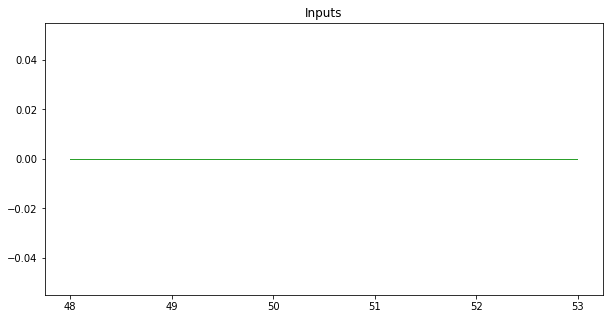

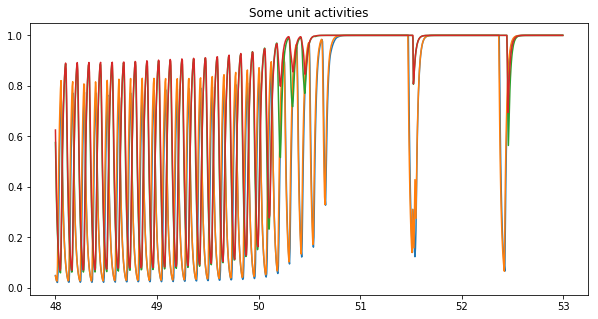

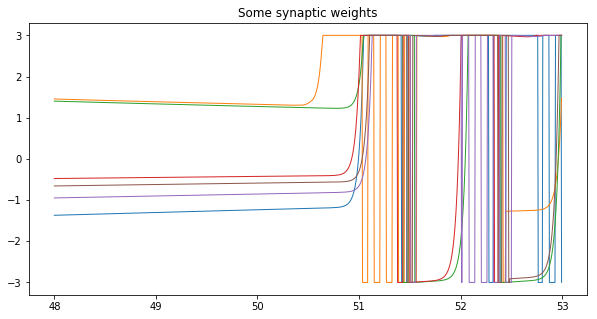

In [22]:
%matplotlib inline
dist_runner.basic_plot()

In [23]:
dist_runner.double_anim(slider=False, interv=30)

In [27]:
dist_runner.annotate('This simulation can show some repeating spatiotemporal patterns (e.g. traveling waves), ', make_history=False)
dist_runner.annotate('that intersperse with periods where all units are maximally active.', make_history=False)
dist_runner.annotate('When it was run, the f = max( min( .999, f), 0.001) was commented out.', make_history=False)
#dist_runner.save(name="proto_rate_density_pickled.pkl")
dist_runner.log()

In [28]:
dist_runner.history

['__init__ at Mon Nov 27 11:09:43 2017',
 'np.random.seed = 19680801',
 "geom['rows'] = 12",
 "geom['columns'] = 12",
 '#This is so the input at each presentation changes.',
 "n_units['inp'] = 3",
 '#A faster learning rate.',
 "syn['lrate'] = 0.05",
 'build()',
 'run(1, 1.000000, 0.000000, 12.000000, 0.500000)',
 'run(1, 1.000000, 0.000000, 12.000000, 0.500000)',
 'run(1, 1.000000, 0.000000, 12.000000, 0.500000)',
 'run(1, 1.000000, 0.000000, 12.000000, 0.500000)',
 'run(1, 1.000000, 0.000000, 5.000000, 0.500000)']

In [ ]:
dist_runner.conn_anim(dist_runner.units, dist_runner.units, slider=False, weights=True)

In [ ]:
dist_runner.activ_anim(0.9, interv=10, slider=False)

In [ ]:
dist_runner.hist_anim()